In [ ]:
# Fix OpenMP conflict
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# GIMBAL Algorithm Demo

This notebook demonstrates the **GIMBAL** (Geometric Manifolds for Body Articulation and Localization) algorithm for 3D pose estimation from multi-view 2D keypoints.

## Overview

GIMBAL uses a hierarchical von Mises–Fisher–Gaussian (vMFG) model combined with MCMC inference (HMC + Gibbs sampling) to reconstruct 3D poses from noisy 2D observations across multiple camera views.

In this demo, we'll:
1. Generate synthetic 3D motion with a simple skeleton
2. Project it to 2D observations from multiple cameras
3. Run the GIMBAL sampler to recover the 3D pose
4. Visualize the results

## 1. Import Required Libraries

We'll import PyTorch for tensor operations and the GIMBAL modules for camera projection, parameter fitting, and MCMC inference.

In [2]:
# Add parent directory to Python path so we can import gimbal package
import sys
from pathlib import Path

# Get the repository root (parent of notebook directory)
repo_root = Path().resolve().parent
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

print(f"✓ Added to path: {repo_root}")

✓ Added to path: C:\Repositories\GIMBAL_Python


In [3]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from gimbal.camera import project_points
from gimbal.fit_params import build_gimbal_parameters
from gimbal.inference import HMCConfig, run_gibbs_sampler

# Set random seed for reproducibility
torch.manual_seed(0)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 2. Generate Synthetic Data

We'll create a simple 2-joint skeleton (root + child) moving in 3D space and observe it from 2 camera views.

In [4]:
device = torch.device("cpu")

# Time steps and skeleton structure
T = 20  # 20 time frames
K = 2   # 2 keypoints (root and child)
C = 2   # 2 cameras

# Skeleton: parent[k] gives the parent of keypoint k (-1 for root)
parent = torch.tensor([-1, 0], dtype=torch.long, device=device)

# Ground-truth 3D motion: root moves along a line
t = torch.linspace(0, 1, T, device=device)
root_traj = torch.stack([
    t * 100.0,                    # x: 0 -> 100
    torch.zeros_like(t),          # y: 0
    torch.ones_like(t) * 1000.0   # z: constant depth
], dim=-1)

# Child is offset from root
offset = torch.tensor([50.0, 0.0, 0.0], device=device)
x_gt = torch.zeros(T, K, 3, device=device)
x_gt[:, 0] = root_traj
x_gt[:, 1] = root_traj + offset

print(f"✓ Generated synthetic 3D motion:")
print(f"  - {T} time frames")
print(f"  - {K} keypoints")
print(f"  - Ground truth shape: {x_gt.shape}")

✓ Generated synthetic 3D motion:
  - 20 time frames
  - 2 keypoints
  - Ground truth shape: torch.Size([20, 2, 3])


### Visualize Ground Truth 3D Trajectories

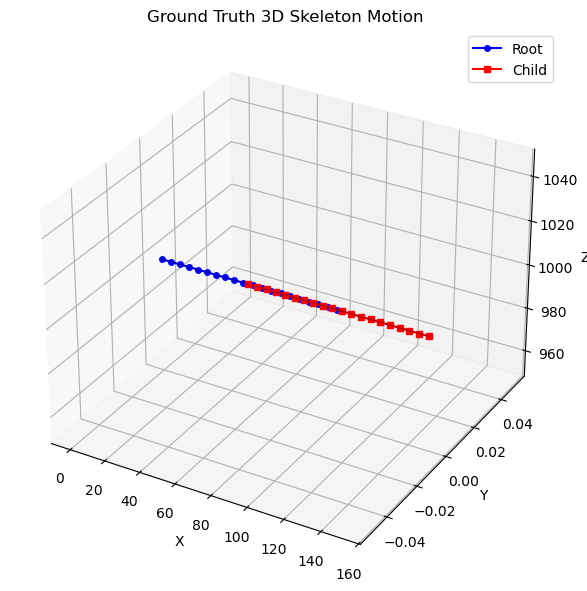

In [5]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot root trajectory
ax.plot(x_gt[:, 0, 0].numpy(), x_gt[:, 0, 1].numpy(), x_gt[:, 0, 2].numpy(), 
        'b-o', label='Root', markersize=4)

# Plot child trajectory
ax.plot(x_gt[:, 1, 0].numpy(), x_gt[:, 1, 1].numpy(), x_gt[:, 1, 2].numpy(), 
        'r-s', label='Child', markersize=4)

# Draw skeleton connections at a few time points
for t_idx in [0, T//2, T-1]:
    ax.plot([x_gt[t_idx, 0, 0], x_gt[t_idx, 1, 0]], 
            [x_gt[t_idx, 0, 1], x_gt[t_idx, 1, 1]], 
            [x_gt[t_idx, 0, 2], x_gt[t_idx, 1, 2]], 'k-', alpha=0.3, linewidth=1)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Ground Truth 3D Skeleton Motion')
ax.legend()
plt.tight_layout()
plt.show()

## 3. Set Up Cameras and Project to 2D

We'll define two simple pinhole cameras and project the 3D keypoints to get noisy 2D observations.

In [6]:
# Camera projection matrices [A | b] shape (C, 3, 4)
proj = torch.zeros(C, 3, 4, device=device)

# Camera 0: front-facing
proj[0, :, :3] = torch.eye(3, device=device)
proj[0, :, 3] = torch.tensor([0.0, 0.0, 0.0], device=device)

# Camera 1: shifted to the side
proj[1, :, :3] = torch.eye(3, device=device)
proj[1, :, 3] = torch.tensor([100.0, 0.0, 0.0], device=device)

# Project 3D points to 2D
y_clean = project_points(x_gt.view(T * K, 3), proj).view(T, K, C, 2)

# Add measurement noise
noise = torch.randn_like(y_clean) * 1.0
y_obs = y_clean + noise

print(f"✓ Created {C} cameras")
print(f"✓ Generated 2D observations with noise")
print(f"  - Observed keypoints shape: {y_obs.shape}")

✓ Created 2 cameras
✓ Generated 2D observations with noise
  - Observed keypoints shape: torch.Size([20, 2, 2, 2])


### Visualize 2D Observations from Both Cameras

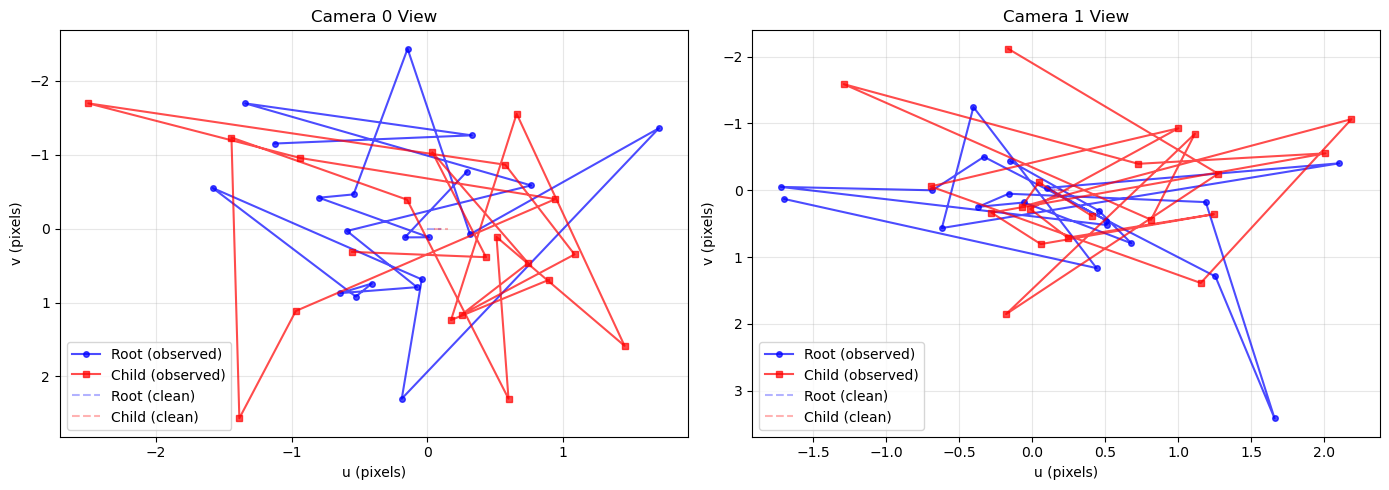

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for c_idx in range(C):
    ax = axes[c_idx]
    
    # Plot observed keypoints
    ax.plot(y_obs[:, 0, c_idx, 0].numpy(), y_obs[:, 0, c_idx, 1].numpy(), 
            'b-o', label='Root (observed)', markersize=4, alpha=0.7)
    ax.plot(y_obs[:, 1, c_idx, 0].numpy(), y_obs[:, 1, c_idx, 1].numpy(), 
            'r-s', label='Child (observed)', markersize=4, alpha=0.7)
    
    # Plot clean projections for comparison
    ax.plot(y_clean[:, 0, c_idx, 0].numpy(), y_clean[:, 0, c_idx, 1].numpy(), 
            'b--', alpha=0.3, label='Root (clean)')
    ax.plot(y_clean[:, 1, c_idx, 0].numpy(), y_clean[:, 1, c_idx, 1].numpy(), 
            'r--', alpha=0.3, label='Child (clean)')
    
    ax.set_xlabel('u (pixels)')
    ax.set_ylabel('v (pixels)')
    ax.set_title(f'Camera {c_idx} View')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.invert_yaxis()  # Image coordinates

plt.tight_layout()
plt.show()

## 4. Build GIMBAL Model Parameters

The GIMBAL model requires several parameter groups:
- **Skeleton parameters**: bone lengths, temporal/spatial variances
- **Pose priors**: von Mises-Fisher distributions for directional constraints
- **Outlier model**: robust mixture parameters for handling bad observations
- **Root dynamics**: initial position and temporal smoothness

We'll estimate these from the ground truth data (in a real scenario, you'd use a small training dataset).

In [8]:
num_states = 3  # Number of discrete pose states for the HMM

params = build_gimbal_parameters(
    x_gt=x_gt, 
    parent=parent, 
    y_obs=y_obs, 
    proj=proj, 
    num_states=num_states
)

print(f"✓ Built GIMBAL parameters:")
print(f"  - Skeleton: {K} keypoints")
print(f"  - Pose states: {num_states}")
print(f"  - Temporal variances η²: {params.skeleton.eta2}")
print(f"  - Bone lengths ρ: {params.skeleton.rho}")
print(f"  - Outlier probabilities β: {params.outlier.beta.mean():.3f}")

✓ Built GIMBAL parameters:
  - Skeleton: 2 keypoints
  - Pose states: 3
  - Temporal variances η²: tensor([27.7008, 27.7008])
  - Bone lengths ρ: tensor([ 0., 50.])
  - Outlier probabilities β: 0.100


c:\Repositories\GIMBAL_Python\.pixi\envs\default\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
c:\Repositories\GIMBAL_Python\.pixi\envs\default\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Repositories\GIMBAL_Python\.pixi\envs\default\Lib\site-packages\sklearn\base.py:1365: ConvergenceWarning: Number of distinct cluster

## 5. Initialize Latent Variables

Before running MCMC, we need to initialize:
- **x**: 3D keypoint positions (initialized from ground truth for this demo)
- **u**: directional vectors (unit vectors from parent to child)
- **s**: discrete pose states
- **h**: heading angles
- **z**: outlier indicators

In [9]:
x_init = x_gt.clone()
u_init = torch.zeros_like(x_init)
s_init = torch.zeros(T, dtype=torch.long, device=device)
h_init = torch.zeros(T, dtype=torch.float32, device=device)
z_init = torch.zeros(T, K, C, device=device)

print(f"✓ Initialized latent variables")
print(f"  - x_init: {x_init.shape}")
print(f"  - u_init: {u_init.shape}")
print(f"  - s_init: {s_init.shape}")
print(f"  - h_init: {h_init.shape}")
print(f"  - z_init: {z_init.shape}")

✓ Initialized latent variables
  - x_init: torch.Size([20, 2, 3])
  - u_init: torch.Size([20, 2, 3])
  - s_init: torch.Size([20])
  - h_init: torch.Size([20])
  - z_init: torch.Size([20, 2, 2])


## 6. Run GIMBAL MCMC Sampler

The sampler alternates between:
1. **HMC** for 3D positions `x` (uses gradient information)
2. **Gibbs** updates for directional vectors `u`
3. **Gibbs** updates for headings `h`
4. **Forward-Filtering Backward-Sampling** for pose states `s`
5. **Bernoulli** updates for outlier indicators `z`

We'll run a small number of iterations for this demo.

In [12]:
num_iters = 5
hmc_cfg = HMCConfig(step_size=0.001, num_steps=5)

print(f"Running GIMBAL sampler for {num_iters} iterations...")
print(f"HMC config: step_size={hmc_cfg.step_size}, num_steps={hmc_cfg.num_steps}")
print()

xs, us, ss, hs, zs = run_gibbs_sampler(
    x_init=x_init,
    u_init=u_init,
    s_init=s_init,
    h_init=h_init,
    z_init=z_init,
    y=y_obs,
    proj=proj,
    params=params,
    num_iters=num_iters,
    hmc_config=hmc_cfg,
)

print(f"\n✓ Sampling complete!")
print(f"  - Collected {num_iters} samples")
print(f"  - Sample shape: {xs.shape}")  # (num_iters, T, K, 3)

Running GIMBAL sampler for 5 iterations...
HMC config: step_size=0.001, num_steps=5



KeyboardInterrupt: 

## 7. Compute Posterior Mean

We'll average the samples (after optional burn-in) to get the posterior mean estimate of the 3D positions.

In [ ]:
burn_in = 2  # Discard first 2 iterations
x_mean = xs[burn_in:].mean(dim=0)

# Compute reconstruction error
recon_error = (x_mean - x_gt).norm(dim=-1).mean()

print(f"✓ Posterior mean computed (using {num_iters - burn_in} samples)")
print(f"  - Mean reconstruction error: {recon_error:.4f} units")
print(f"\nPosterior mean for first 3 frames, root joint:")
print(x_mean[:3, 0])

## 8. Visualize Results

### 8.1 Compare Ground Truth vs. Posterior Mean in 3D

In [ ]:
fig = plt.figure(figsize=(14, 6))

# Ground truth
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(x_gt[:, 0, 0].numpy(), x_gt[:, 0, 1].numpy(), x_gt[:, 0, 2].numpy(), 
         'b-o', label='Root (GT)', markersize=4)
ax1.plot(x_gt[:, 1, 0].numpy(), x_gt[:, 1, 1].numpy(), x_gt[:, 1, 2].numpy(), 
         'r-s', label='Child (GT)', markersize=4)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('Ground Truth')
ax1.legend()

# Posterior mean
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(x_mean[:, 0, 0].numpy(), x_mean[:, 0, 1].numpy(), x_mean[:, 0, 2].numpy(), 
         'b-o', label='Root (Est)', markersize=4, alpha=0.8)
ax2.plot(x_mean[:, 1, 0].numpy(), x_mean[:, 1, 1].numpy(), x_mean[:, 1, 2].numpy(), 
         'r-s', label='Child (Est)', markersize=4, alpha=0.8)

# Overlay ground truth as dashed
ax2.plot(x_gt[:, 0, 0].numpy(), x_gt[:, 0, 1].numpy(), x_gt[:, 0, 2].numpy(), 
         'b--', alpha=0.3, label='Root (GT)')
ax2.plot(x_gt[:, 1, 0].numpy(), x_gt[:, 1, 1].numpy(), x_gt[:, 1, 2].numpy(), 
         'r--', alpha=0.3, label='Child (GT)')

ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title('GIMBAL Reconstruction')
ax2.legend()

plt.tight_layout()
plt.show()

### 8.2 Per-Frame Reconstruction Error

In [ ]:
frame_errors = (x_mean - x_gt).norm(dim=-1)  # (T, K)

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(frame_errors[:, 0].numpy(), 'b-o', label='Root', markersize=4)
ax.plot(frame_errors[:, 1].numpy(), 'r-s', label='Child', markersize=4)
ax.set_xlabel('Frame')
ax.set_ylabel('Reconstruction Error')
ax.set_title('Per-Frame 3D Reconstruction Error')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 8.3 Sample Trajectories (MCMC Trace)

Let's visualize the MCMC trace for the root joint at a single time point to see convergence.

In [ ]:
t_idx = 10  # Middle frame
joint_idx = 0  # Root

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for dim_idx, dim_name in enumerate(['X', 'Y', 'Z']):
    ax = axes[dim_idx]
    samples = xs[:, t_idx, joint_idx, dim_idx].numpy()
    gt_val = x_gt[t_idx, joint_idx, dim_idx].item()
    
    ax.plot(samples, 'k-o', markersize=3, alpha=0.7)
    ax.axhline(gt_val, color='r', linestyle='--', label='Ground Truth')
    ax.set_xlabel('MCMC Iteration')
    ax.set_ylabel(f'{dim_name} coordinate')
    ax.set_title(f'Trace Plot: {dim_name} (Frame {t_idx}, Root)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary

This notebook demonstrated the GIMBAL algorithm for 3D pose estimation from multi-view 2D keypoints:

1. ✅ Generated synthetic 3D skeleton motion with 2 joints
2. ✅ Projected to noisy 2D observations from 2 cameras
3. ✅ Estimated model parameters from ground truth
4. ✅ Ran MCMC sampler (HMC + Gibbs) to recover 3D pose
5. ✅ Visualized reconstruction quality and convergence

### Key Takeaways

- GIMBAL combines **geometric constraints** (skeleton structure, directional priors) with **probabilistic inference** (MCMC sampling)
- The hierarchical vMFG model captures both spatial relationships and temporal smoothness
- HMC efficiently explores the high-dimensional 3D position space
- Gibbs updates handle discrete states and directional variables analytically

### Next Steps

- Increase `num_iters` for better convergence (e.g., 100-1000 iterations)
- Experiment with more complex skeletons (more joints)
- Add more cameras or increase observation noise
- Tune HMC parameters (`step_size`, `num_steps`)
- Try different numbers of pose states in the HMM